<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#背景" data-toc-modified-id="背景-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>背景</a></span></li><li><span><a href="#目的" data-toc-modified-id="目的-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>目的</a></span></li><li><span><a href="#初期仮説" data-toc-modified-id="初期仮説-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>初期仮説</a></span></li><li><span><a href="#各列のデータ型を確認" data-toc-modified-id="各列のデータ型を確認-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>各列のデータ型を確認</a></span></li><li><span><a href="#データ補正" data-toc-modified-id="データ補正-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>データ補正</a></span></li><li><span><a href="#ペルソナ作成方針" data-toc-modified-id="ペルソナ作成方針-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ペルソナ作成方針</a></span><ul class="toc-item"><li><span><a href="#75パーセンタイルの電力をプロット" data-toc-modified-id="75パーセンタイルの電力をプロット-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>75パーセンタイルの電力をプロット</a></span></li><li><span><a href="#ペルソナ作成対象の特定" data-toc-modified-id="ペルソナ作成対象の特定-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>ペルソナ作成対象の特定</a></span><ul class="toc-item"><li><span><a href="#参考" data-toc-modified-id="参考-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>参考</a></span></li></ul></li></ul></li><li><span><a href="#month,-hour,-weekday-でグルーピングして平均を計算" data-toc-modified-id="month,-hour,-weekday-でグルーピングして平均を計算-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>month, hour, weekday でグルーピングして平均を計算</a></span></li><li><span><a href="#t-SNEによる次元圧縮" data-toc-modified-id="t-SNEによる次元圧縮-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>t-SNEによる次元圧縮</a></span><ul class="toc-item"><li><span><a href="#データの標準化" data-toc-modified-id="データの標準化-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>データの標準化</a></span><ul class="toc-item"><li><span><a href="#データを保存" data-toc-modified-id="データを保存-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>データを保存</a></span></li></ul></li><li><span><a href="#クラスタリング" data-toc-modified-id="クラスタリング-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>クラスタリング</a></span><ul class="toc-item"><li><span><a href="#次元削減後の（曜日-時間）のプロット" data-toc-modified-id="次元削減後の（曜日-時間）のプロット-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>次元削減後の（曜日-時間）のプロット</a></span></li><li><span><a href="#K-means++によるクラスタリング（曜日-時間）" data-toc-modified-id="K-means++によるクラスタリング（曜日-時間）-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>K-means++によるクラスタリング（曜日-時間）</a></span></li><li><span><a href="#エルボー法によるクラスター数の評価" data-toc-modified-id="エルボー法によるクラスター数の評価-8.2.3"><span class="toc-item-num">8.2.3&nbsp;&nbsp;</span>エルボー法によるクラスター数の評価</a></span></li><li><span><a href="#シルエット分析によるクラスター数の評価" data-toc-modified-id="シルエット分析によるクラスター数の評価-8.2.4"><span class="toc-item-num">8.2.4&nbsp;&nbsp;</span>シルエット分析によるクラスター数の評価</a></span></li></ul></li></ul></li><li><span><a href="#ペルソナの分析（曜日-時間）" data-toc-modified-id="ペルソナの分析（曜日-時間）-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>ペルソナの分析（曜日-時間）</a></span><ul class="toc-item"><li><span><a href="#クラスター毎にユーザを分類" data-toc-modified-id="クラスター毎にユーザを分類-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>クラスター毎にユーザを分類</a></span></li><li><span><a href="#各クラスタを擬人化し、1日の電力量をプロット" data-toc-modified-id="各クラスタを擬人化し、1日の電力量をプロット-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>各クラスタを擬人化し、1日の電力量をプロット</a></span><ul class="toc-item"><li><span><a href="#クラスター-0-の場合（データ数：83）" data-toc-modified-id="クラスター-0-の場合（データ数：83）-9.2.1"><span class="toc-item-num">9.2.1&nbsp;&nbsp;</span>クラスター 0 の場合（データ数：83）</a></span></li><li><span><a href="#クラスター-1-の場合（データ数：114）" data-toc-modified-id="クラスター-1-の場合（データ数：114）-9.2.2"><span class="toc-item-num">9.2.2&nbsp;&nbsp;</span>クラスター 1 の場合（データ数：114）</a></span></li><li><span><a href="#クラスター-2-の場合（データ数：45）" data-toc-modified-id="クラスター-2-の場合（データ数：45）-9.2.3"><span class="toc-item-num">9.2.3&nbsp;&nbsp;</span>クラスター 2 の場合（データ数：45）</a></span></li><li><span><a href="#クラスター-3-の場合（データ数：77）" data-toc-modified-id="クラスター-3-の場合（データ数：77）-9.2.4"><span class="toc-item-num">9.2.4&nbsp;&nbsp;</span>クラスター 3 の場合（データ数：77）</a></span></li></ul></li></ul></li><li><span><a href="#ペルソナの分析（月-時間）" data-toc-modified-id="ペルソナの分析（月-時間）-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>ペルソナの分析（月-時間）</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#クラスター-0-の場合（データ数：177）" data-toc-modified-id="クラスター-0-の場合（データ数：177）-10.0.1"><span class="toc-item-num">10.0.1&nbsp;&nbsp;</span>クラスター 0 の場合（データ数：177）</a></span></li><li><span><a href="#クラスター-1-の場合（データ数：142）" data-toc-modified-id="クラスター-1-の場合（データ数：142）-10.0.2"><span class="toc-item-num">10.0.2&nbsp;&nbsp;</span>クラスター 1 の場合（データ数：142）</a></span></li></ul></li></ul></li></ul></div>

# 電力使用量に基づく在宅時間推定

## 背景
EC市場への参入事業者の増加に伴い、全国対応、当日配送等の配送サービスが多様化する一方で、再配達の増加が収益を圧迫している。  
労働人口の減少や労働環境の問題により、物流の担い手も減っていく事が予想される為、再配達を減少させる事が収益・労働環境の向上の観点から急務となっている。


## 目的
電力会社からスマートメータの [データ](https://archive.ics.uci.edu/ml/machine-learning-databases/00321/) を購入し、電力量から顧客（企業以外）の在宅時間を予測する事で、再配達数を減少させる。

## 初期仮説

- 顧客には企業と一般家庭に分類できると思われる。
- 一般家庭には在宅パターンがあると思われる。
- 不在時にも電力需要は存在するはず。
- 不在時（応対不能時含む）は在宅時に比べて電力量の変動が少ないと思われる。
- 不在 => 在宅時は電力量が増加、在宅 => 不在の切り替わり時は減少していくと思われる。
- 一定時間、電力需要が低い状態になったら不在と見なせると思われる。
- 在宅パターンは電力量、時間、曜日、月で細分化されると思われる。

# データ分析

__[データ定義](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#)__
- 各値は15分毎の電力。電力量に変換するには4で割る。（4で乗算するのではと思うが、定義に従う）
- 各列は顧客を表す。
- ある顧客は2011年以降に作成されている。この場合、消費はゼロとみなされる。
- 1日は96分割（24*4）
- 毎年 3月になると23時間扱いで AM1:00-AM2:00の消費はゼロとみなされる。
- 毎年10月になると25時間扱いで AM1:00-AM2:00の消費は2時間分が合算されている。

>Data set has no missing values.  
    Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.  
    Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.  
    All time labels report to Portuguese hour. However all days present 96 measures (24*15).   
    Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points.   
    Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours. 

In [1]:
import pandas as pd 
import numpy as np
import re
import copy
from datetime import datetime as dt

from matplotlib import pyplot as plt
import seaborn as sns

# warningの抑止
import warnings
warnings.filterwarnings('ignore')

In [2]:
# データを読み込む
df = pd.read_table("data/LD2011_2014.txt", sep=";")

# 行数と列数を確認
df.shape

(140256, 371)

In [3]:
# 中身を確認
pd.set_option("display.max_columns", 400)
df.head()

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,MT_051,MT_052,MT_053,MT_054,MT_055,MT_056,MT_057,MT_058,MT_059,MT_060,MT_061,MT_062,MT_063,MT_064,MT_065,MT_066,MT_067,MT_068,MT_069,MT_070,MT_071,MT_072,MT_073,MT_074,MT_075,MT_076,MT_077,MT_078,MT_079,MT_080,MT_081,MT_082,MT_083,MT_084,MT_085,MT_086,MT_087,MT_088,MT_089,MT_090,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_109,MT_110,MT_111,MT_112,MT_113,MT_114,MT_115,MT_116,MT_117,MT_118,MT_119,MT_120,MT_121,MT_122,MT_123,MT_124,MT_125,MT_126,MT_127,MT_128,MT_129,MT_130,MT_131,MT_132,MT_133,MT_134,MT_135,MT_136,MT_137,MT_138,MT_139,MT_140,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_151,MT_152,MT_153,MT_154,MT_155,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165,MT_166,MT_167,MT_168,MT_169,MT_170,MT_171,MT_172,MT_173,MT_174,MT_175,MT_176,MT_177,MT_178,MT_179,MT_180,MT_181,MT_182,MT_183,MT_184,MT_185,MT_186,MT_187,MT_188,MT_189,MT_190,MT_191,MT_192,MT_193,MT_194,MT_195,MT_196,MT_197,MT_198,MT_199,MT_200,MT_201,MT_202,MT_203,MT_204,MT_205,MT_206,MT_207,MT_208,MT_209,MT_210,MT_211,MT_212,MT_213,MT_214,MT_215,MT_216,MT_217,MT_218,MT_219,MT_220,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,MT_230,MT_231,MT_232,MT_233,MT_234,MT_235,MT_236,MT_237,MT_238,MT_239,MT_240,MT_241,MT_242,MT_243,MT_244,MT_245,MT_246,MT_247,MT_248,MT_249,MT_250,MT_251,MT_252,MT_253,MT_254,MT_255,MT_256,MT_257,MT_258,MT_259,MT_260,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270,MT_271,MT_272,MT_273,MT_274,MT_275,MT_276,MT_277,MT_278,MT_279,MT_280,MT_281,MT_282,MT_283,MT_284,MT_285,MT_286,MT_287,MT_288,MT_289,MT_290,MT_291,MT_292,MT_293,MT_294,MT_295,MT_296,MT_297,MT_298,MT_299,MT_300,MT_301,MT_302,MT_303,MT_304,MT_305,MT_306,MT_307,MT_308,MT_309,MT_310,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"71,7703349282297",0,0,0,0,0,0,"260,416666666667","45,7217504898759",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"68,203368683718",0,"38,3422459893048","20,3639846743295",0,"1935,18518518519","158,006362672322","1965,43778801843",0,0,"838,461538461538",0,"50,7562076749436","24,5706051873199",0,"137,885196374622","80,7970112079701",0,"74,5622119815668","76,7927631578947","41,4825870646766",0,0,0,"93,2917316692668",0,"39,5888594164456","45,7174556213018",0,0,0,"13,4228187919463","22,123745819398","205,83596214511","327,859237536657","920,863309352518","285,607755406413","266,521026761333","1826,27118644068","218,274111675127","12166,6666666667","76,6129032258064","148,867313915858","272,935779816514","428,4140969163","173,089071383449","235,492957746479","319,354838709677","447,761194029851","288,135593220339","110,538373424971","345,578231292517","4235,29411764706","260,9375","472,868217054264",84,"232,558139534884","603,036876355748","199,59266802444","207,532051282051","1328,90365448505","113,074204946996","680,529300567108","204,301075268817","1278,48101265823","81,7282665278501",444,"517,333333333333",0,"189

__Unnamed: 0__が電力の計測時刻、__MT_***__が顧客、その列値は電力を表す。

Unnamed列を、年月日時分 + 曜日 で分割する。

In [4]:
# Unnamed列を、年月日時分秒 + 曜日 で分割する。（秒は全てゼロなので削除）
df["year"] = df.iloc[:, 0].apply(
    lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S').year)

df["month"] = df.iloc[:, 0].apply(
    lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S').month)

df["day"] = df.iloc[:, 0].apply(
    lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S').day)

df["weekday"] = df.iloc[:, 0].apply(
    lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S').weekday())

df["hour"] = df.iloc[:, 0].apply(
    lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S').hour)

df["minute"] = df.iloc[:, 0].apply(
    lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S').minute)

In [5]:
# 複合インデックスとして再作成
df.set_index(["year", "month", "day", "weekday", "hour", "minute"], inplace=True)

In [6]:
# Unnamed: 0列を削除
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

MT_001 MT_002 MT_003 MT_004 MT_005 MT_006  \
year month day weekday hour minute                                             
2011 1     1   5       0    15          0      0      0      0      0      0   
                            30          0      0      0      0      0      0   
                            45          0      0      0      0      0      0   
                       1    0           0      0      0      0      0      0   
                            15          0      0      0      0      0      0   

                                   MT_007 MT_008 MT_009 MT_010 MT_011 MT_012  \
year month day weekday hour minute                                             
2011 1     1   5       0    15          0      0      0      0      0      0   
                            30          0      0      0      0      0      0   
                            45          0      0      0      0      0      0   
                       1    0           0      0      0      0      0      0   
                            15          0      0      0      0      0      0   

                                   MT_013 MT_014 MT_015 MT_016 MT_017 MT_018  \
year month day weekday hour minute                                             
2011 1     1   5       0    15          0      0      0      0      0      0   
                            30          0      0      0      0      0      0   
                            45          0      0      0      0      0      0   
                       1    0           0      0      0      0      0      0   
                            15          0      0      0      0      0      0   

                                   MT_019 MT_020 MT_021 MT_022 MT_023 MT_024  \
year month day weekday hour minute                                             
2011 1     1   5       0    15          0      0      0      0      0      0   
                            30          0      0      0      0      0      0   
                            45          0      0      0      0      0      0   
                       1    0           0      0      0      0      0      0   
                            15          0      0      0      0      0      0   

                                   MT_025 MT_026 MT_027 MT_028 MT_029 MT_030  \
year month day weekday hour minute                                             
2011 1     1   5       0    15          0      0      0      0      0      0   
                            30          0      0      0      0      0      0   
                            45          0      0      0      0      0      0   
                       1    0           0      0      0      0      0      0   
                            15          0      0      0      0      0      0   

                                   MT_031 MT_032 MT_033 MT_034 MT_035 MT_036  \
year month day weekday hour minute                                             
2011 1     1   5       0    15          0      0      0      0      0      0   
                            30          0      0      0      0      0      0   
                            45          0      0      0      0      0      0   
                       1    0           0      0      0      0      0      0   
                            15          0      0      0      0      0      0   

                                   MT_037 MT_038 MT_039 MT_040 MT_041 MT_042  \
year month day weekday hour minute                                             
2011 1     1   5       0    15          0      0      0      0      0      0   
                            30          0      0      0      0      0      0   
                            45          0      0      0      0      0      0   
                       1    0           0      0      0      0      0      0   
                            15          0      0      0      0      0      0   

                                   MT_043 MT_044 MT_045 MT_046 MT_047 MT_048  \
year month day weekday hour 

## 各列のデータ型を確認

In [7]:
df.dtypes

MT_001     object
MT_002     object
MT_003     object
MT_004     object
MT_005     object
MT_006     object
MT_007     object
MT_008     object
MT_009     object
MT_010     object
MT_011     object
MT_012     object
MT_013     object
MT_014     object
MT_015     object
MT_016     object
MT_017     object
MT_018     object
MT_019     object
MT_020     object
MT_021     object
MT_022     object
MT_023     object
MT_024     object
MT_025     object
MT_026     object
MT_027     object
MT_028     object
MT_029     object
MT_030     object
           ...   
MT_341     object
MT_342     object
MT_343     object
MT_344     object
MT_345     object
MT_346     object
MT_347     object
MT_348     object
MT_349     object
MT_350     object
MT_351     object
MT_352     object
MT_353     object
MT_354     object
MT_355     object
MT_356     object
MT_357     object
MT_358     object
MT_359     object
MT_360     object
MT_361     object
MT_362    float64
MT_363     object
MT_364     object
MT_365    

## データ補正

数値型ではなくobject型が多い。理由は、小数点はカンマになっている為。

In [8]:
df["MT_124"].iloc[0]

'71,7703349282297'

数値に直せるように編集

In [9]:
# カンマを小数点に変更
df.replace(",", ".", regex=True, inplace=True)

# 数値(float)型へ変換
df = df.astype("float")

# 電力量に変換
df = df / 4

# 要約統計量でゼロを取り込みたくないのでNaNで埋める
df.replace(0, np.NaN, inplace=True)
df.dtypes

MT_001    float64
MT_002    float64
MT_003    float64
MT_004    float64
MT_005    float64
MT_006    float64
MT_007    float64
MT_008    float64
MT_009    float64
MT_010    float64
MT_011    float64
MT_012    float64
MT_013    float64
MT_014    float64
MT_015    float64
MT_016    float64
MT_017    float64
MT_018    float64
MT_019    float64
MT_020    float64
MT_021    float64
MT_022    float64
MT_023    float64
MT_024    float64
MT_025    float64
MT_026    float64
MT_027    float64
MT_028    float64
MT_029    float64
MT_030    float64
           ...   
MT_341    float64
MT_342    float64
MT_343    float64
MT_344    float64
MT_345    float64
MT_346    float64
MT_347    float64
MT_348    float64
MT_349    float64
MT_350    float64
MT_351    float64
MT_352    float64
MT_353    float64
MT_354    float64
MT_355    float64
MT_356    float64
MT_357    float64
MT_358    float64
MT_359    float64
MT_360    float64
MT_361    float64
MT_362    float64
MT_363    float64
MT_364    float64
MT_365    

In [10]:
df.index.levels[0]

Int64Index([2011, 2012, 2013, 2014, 2015], dtype='int64', name='year')

2011 - 2015年 までのデータがある事がわかる。

In [11]:
print("### 2011 shape" ,df.loc[2011].shape)
print("### 2012 shape" ,df.loc[2012].shape)
print("### 2013 shape" ,df.loc[2013].shape)
print("### 2014 shape" ,df.loc[2014].shape)
print("### 2015 shape" ,df.loc[2015].shape)

### 2011 shape (35039, 370)
### 2012 shape (35136, 370)
### 2013 shape (35040, 370)
### 2014 shape (35040, 370)
### 2015 shape (1, 370)


__1日は 96 (24*4) 分割、１年は 96 * 365 = 35040 分割されているはず。2012年は閏年の為、１日分のレコードが多い。（35040 + 96 = 35136)__

## ペルソナ作成方針

<b><font color=red>今回は、特定の顧客（＝ 現在、居住している顧客）の在宅パターンではなく、サンプリングデータから作成された在宅パターンを作る事が目的なので、年毎にデータ分析しない。<br>2011-2015分のデータから 75%パーセンタイルの電力量を元にターゲットを絞りペルソナを作成する。</font></b>

### 75パーセンタイルの電力をプロット

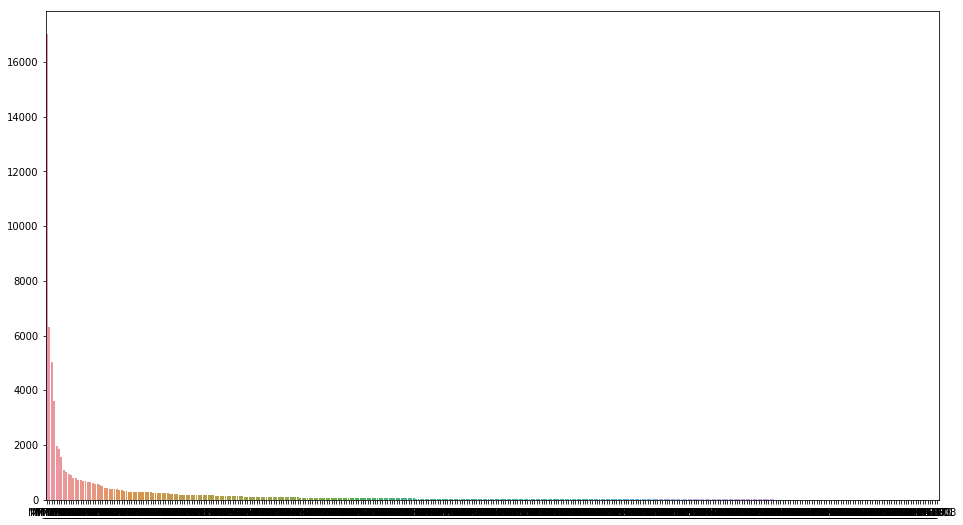

In [12]:
# 75パーセンタイルのデータをソート
per_75 = pd.DataFrame(df.describe().loc["75%"]).sort_values(by="75%", ascending=False)

plt.figure(figsize=(16, 9))
sns.barplot(x=per_75.index, y=per_75.iloc[:,0].values, data=per_75)

__画像左側は、75%タイルの電力量が抜きん出ており、企業（除外対象）と思われる。__

{'boxes': [<matplotlib.lines.Line2D at 0x1a44f00908>],
 'caps': [<matplotlib.lines.Line2D at 0x1a45307c50>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a452fc908>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a452fc4e0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a44f00a58>,
  <matplotlib.lines.Line2D at 0x1a44f00ef0>]}

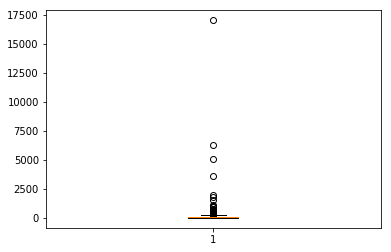

In [13]:
# 箱ひげ図
plt.boxplot(per_75.iloc[:,0].values)

In [14]:
per_75.describe()

,75%
count,370.000000
mean,201.348156
std,1010.747559
min,0.651607
25%,20.552962
50%,40.784516
75%,104.486466
max,17025.000000


In [15]:
# 四分位範囲：75パーセンタイル（第三四分位数）－25パーセンタイル（第一四分位数）
iqr = per_75.describe().loc["75%"] - per_75.describe().loc["25%"]
iqr.values

array([83.93350385])

In [16]:
# 4分位の上限閾値
104.486466 + 1.5 * iqr.values

array([230.38672178])

### ペルソナ作成対象の特定

電力量が 230.38672178 kwh 以上の顧客は企業とみなし、分析から外す。

In [17]:
target_customes = per_75[per_75["75%"] < 230.38672178]
target_customes.index

Index(['MT_223', 'MT_369', 'MT_210', 'MT_104', 'MT_294', 'MT_231', 'MT_360',
       'MT_246', 'MT_255', 'MT_310',
       ...
       'MT_023', 'MT_141', 'MT_019', 'MT_347', 'MT_133', 'MT_007', 'MT_160',
       'MT_093', 'MT_001', 'MT_003'],
      dtype='object', length=319)

#### 参考
[平成２４年度 エネルギー使用合理化促進基盤整備事業 （待機時消費電力調査）](http://www.meti.go.jp/meti_lib/report/2013fy/E003416.pdf)によると  
一般家庭の消費電力量は 4,432 kWh/年・世帯  
1日に換算すると、4,432 / 365 = 12.14 kWh/日・世帯

一般家庭の消費電力量の裏を取った上で外れ値を削除したかったが、本データ（ポルトガル）と電力量に乖離がありすぎた為、断念。

# ペルソナ作成

In [18]:
# ターゲットとなる顧客のカラム名
target_cols = target_customes.index.values
target_cols.sort()

# ターゲットとなる顧客のみを抽出
target_df = df[target_cols]

## month, hour, weekday でグルーピングして平均を計算
※NaNに置換した事で、平均算出時は計算対象外

In [19]:
# hour(level=3), weekday(level=4) でグルーピングして平均を計算(NaNは対象外)
weekday_hour_df = target_df.groupby(level=[3, 4]).mean()

# month(level=1), hour(level=3) でグルーピングして平均を計算(NaNは対象外)
month_hour_df = target_df.groupby(level=[1, 3]).mean()

In [20]:
weekday_hour_df.head()

MT_001    MT_002    MT_003     MT_004     MT_005     MT_006  \
weekday hour                                                                  
0       0     1.132268  6.252775  0.905471  28.747378  13.109756  41.220001   
        1     1.148030  5.598731  0.997471  24.200100  11.365446  35.286577   
        2     1.135184  5.277088  1.275891  21.850403  10.580433  32.039070   
        3     1.141725  5.233768  1.447440  20.551758  10.357115  30.424202   
        4     1.155292  5.288414  1.445710  19.581618  10.127971  29.021412   

                MT_007     MT_008     MT_009     MT_010    MT_011     MT_012  \
weekday hour                                                                   
0       0     1.506618  55.827650  12.088827  12.213633  9.100876  29.844225   
        1     1.330414  49.302741  11.079685  11.217554  7.954664  27.767857   
        2     1.258403  44.646304  10.590425  10.647815  7.489535  26.468465   
        3     1.223972  49.117770  10.300905  10.198788  7.234425  25.590805   
        4     1.211145  45.811083   9.989811  10.014725  7.118440  25.127280   

                 MT_013    MT_014    MT_015    MT_016     MT_017     MT_018  \
weekday hour                                                                  
0       0     10.563887  8.243774  9.754864  8.780632  10.711925  49.201532   
        1     10.768873  7.697830  8.692947  7.433114   9.203264  41.263914   
        2     10.061159  7.376209  8.197940  6.734871   8.477547  38.113541   
        3      9.993491  7.130039  7.992503  6.136150   8.109144  35.549490   
        4     10.264825  6.945094  7.965111  6.109626   7.904198  34.772390   

                MT_019     MT_020     MT_021    MT_022    MT_023    MT_024  \
weekday hour                                                                 
0       0     2.002249  10.469570  36.070839  5.517228  2.266430  6.681289   
        1     1.771197   9.111156  31.541793  5.008586  1.932676  5.667069   
        2     1.635566   8.224838  28.456081  4.812516  1.733368  5.098784   
        3     1.559749   7.698729  26.124862  4.390879  1.560846  4.930889   
        4     1.511739   7.299938  25.032723  4.234221  1.432176  4.857956   

                 MT_025    MT_026    MT_027     MT_028     MT_029     MT_030  \
weekday hour                                                                   
0       0     45.285434  5.126916  5.342686  17.414007  10.841137  10.270001   
        1     40.952959  4.206925  4.395224  15.213596   9.475121   9.079230   
        2     37.318070  3.872261  3.963678  14.043084   8.683928   8.496659   
        3     35.815004  3.667818  3.786454  13.213189   8.240720   8.192826   
        4     36.192631  3.599333  3.693841  12.347661   8.040803   7.795012   

                 MT_031    MT_032    MT_033    MT_034     MT_035    MT_036  \
weekday hour                                                                 
0       0     19.615713  7.121498  8.587067  4.293636  27.003436  3.649265   
        1     16.768197  7.047593  7.456306  3.916953  23.654671  3.722579   
        2     15.231494  6.490910  7.008613  3.702618  22.095349  3.616376   
        3     14.678883  6.716880  6.795483  3.548331  21.625592  3.607469   
        4     16.286954  6.672218  6.740482  3.473550  24.593624  3.575266   

                 MT_037     MT_038     MT_039     MT_040     MT_041    MT_042  \
weekday hour                                                                    
0       0     26.234615  24.331377  10.449465  20.594553  24.944644  9.093328   
        1     22.721113  21.650528   8.433246  18.831586  23.871992  8.009837   
        2     20.816137  20.148835   7.398174  16.999720  22.558072  7.342140   
        3     20.608237  19.379752   6.975881  16.245100  21.731910  6.917242   
        4     20.565887  21.655217   6.849824  16.492266  21.555398  6.760940   

                MT_044     MT_045     MT_046    MT_047    MT_048     MT_050  \
weekday hour                                 

In [21]:
month_hour_df.head()

MT_001    MT_002    MT_003     MT_004     MT_005     MT_006  \
month weekday                                                                  
1     0        1.549658  6.761316  2.917439  29.901094  16.474408  57.594532   
      1        1.439740  6.799092  2.449184  30.297634  16.268329  59.031653   
      2        1.334891  6.825287  2.125593  30.687427  16.408518  58.452580   
      3        1.479509  6.495661  2.089765  31.296657  16.354611  58.369844   
      4        1.591179  6.617701  1.804103  31.391283  16.138993  57.785910   

                 MT_007     MT_008     MT_009     MT_010     MT_011  \
month weekday                                                         
1     0        1.114955  67.441239  18.863398  17.009150  12.648852   
      1        1.076640  66.627335  18.854193  17.596726  12.693580   
      2        1.063706  68.068457  18.560541  17.661530  12.666136   
      3        1.071006  67.759378  18.256883  17.887237  12.699932   
      4        1.119825  69.757403  18.293605  17.339571  12.932913   

                  MT_012     MT_013     MT_014     MT_015    MT_016  \
month weekday                                                         
1     0        47.553746  21.034650  15.378530  13.482885  9.493778   
      1        47.585605  21.002225  16.242745  14.367978  9.465209   
      2        46.310949  20.871585  15.923545  13.053923  9.442752   
      3        48.094617  21.897791  16.515825  14.061721  9.353698   
      4        47.390293  21.596910  16.026338  14.192977  9.541690   

                  MT_017     MT_018    MT_019     MT_020     MT_021    MT_022  \
month weekday                                                                   
1     0        13.328063  71.036342  2.332073  11.507046  47.317069  8.511501   
      1        13.494971  71.753052  2.334309  11.548143  49.265399  8.202245   
      2        13.543271  70.978696  2.340105  11.723503  48.962034  8.208731   
      3        13.330962  70.945521  2.254768  11.456365  49.014189  8.345447   
      4        13.335983  70.930742  2.293444  11.557699  49.018220  8.444021   

                 MT_023    MT_024     MT_025    MT_026    MT_027     MT_028  \
month weekday                                                                 
1     0        2.424724  8.887523  64.895421  6.427063  6.016081  19.945098   
      1        2.410179  8.595616  66.882580  6.322986  6.155952  19.936931   
      2        2.432265  8.719314  66.979062  6.415677  6.323838  20.411360   
      3        2.425062  8.753956  64.618872  6.385546  6.185222  20.209059   
      4        2.486696  8.680357  65.764101  6.489875  6.307046  20.115341   

                  MT_029     MT_030     MT_031     MT_032     MT_033  \
month weekday                                                          
1     0        20.915619  10.475983  26.172468  10.304778  10.990540   
      1        23.768291  10.505162  26.071955  10.279505  12.076696   
      2        23.795547  10.866703  26.611940   9.953622  11.742444   
      3        24.990747  10.846403  26.066328  10.047421  11.722408   
      4        25.176036  10.922958  26.237704   9.756813  12.227410   

                 MT_034     MT_035     MT_036     MT_037     MT_038  \
month weekday                                                         
1     0        3.468259  33.598061  11.272080  31.289909  33.769476   
      1        3.493958  33.467231  12.638244  31.478467  34.021918   
      2        3.586055  33.103055  12.010734  31.480626  34.148280   
      3        3.429057  33.590315  12.494481  31.368778  34.774178   
      4        3.541420  34.515140  12.920501  31.685901  35.475347   

                  MT_039     MT_040     MT_041     MT_042    MT_044  \
month weekday                                                         
1     0        11.361222  33.759510  28.674686  12.408418  8.669985   
      1        11.439461  34.920158  29.266542  12.281513  8.688136   
      2        11.586929  35.067843  27.926728  12.

In [22]:
weekday_hour_df.shape, month_hour_df.shape

((168, 319), (84, 319))

In [23]:
# 行数の期待値
7 * 24, 12 * 7

(168, 84)

__319顧客に対して、曜日-時間、月-時間 による特徴量が、それぞれ168、84種類__

In [24]:
# 欠損値の確認
(weekday_hour_df.isnull().sum()).sum() , (month_hour_df.isnull().sum()).sum()

(0, 98)

月-時間で集約した場合、欠損値があるので、各行の平均で補完する。

In [25]:
# 補完に使用する値
month_hour_df[:5].mean(axis=1)

month  weekday
1      0          40.645984
       1          40.140306
       2          39.857092
       3          40.127729
       4          41.117115
dtype: float64

In [26]:
# 補完前
month_hour_df.head()["MT_109"]

month  weekday
1      0                NaN
       1                NaN
       2                NaN
       3          10.638298
       4                NaN
Name: MT_109, dtype: float64

In [27]:
# シリーズ内の欠損値を平均で埋める
def fill_mean(s):
    s.fillna(s.mean(), inplace=True)
    
# 行毎に fill_mean を適用    
month_hour_df.fillna(month_hour_df.apply(fill_mean, axis=1), inplace=True)

In [28]:
# 補完後
month_hour_df.head()["MT_109"]

month  weekday
1      0          40.645984
       1          40.140306
       2          39.857092
       3          10.638298
       4          41.117115
Name: MT_109, dtype: float64

In [29]:
# 確認
month_hour_df.head()

MT_001    MT_002    MT_003     MT_004     MT_005     MT_006  \
month weekday                                                                  
1     0        1.549658  6.761316  2.917439  29.901094  16.474408  57.594532   
      1        1.439740  6.799092  2.449184  30.297634  16.268329  59.031653   
      2        1.334891  6.825287  2.125593  30.687427  16.408518  58.452580   
      3        1.479509  6.495661  2.089765  31.296657  16.354611  58.369844   
      4        1.591179  6.617701  1.804103  31.391283  16.138993  57.785910   

                 MT_007     MT_008     MT_009     MT_010     MT_011  \
month weekday                                                         
1     0        1.114955  67.441239  18.863398  17.009150  12.648852   
      1        1.076640  66.627335  18.854193  17.596726  12.693580   
      2        1.063706  68.068457  18.560541  17.661530  12.666136   
      3        1.071006  67.759378  18.256883  17.887237  12.699932   
      4        1.119825  69.757403  18.293605  17.339571  12.932913   

                  MT_012     MT_013     MT_014     MT_015    MT_016  \
month weekday                                                         
1     0        47.553746  21.034650  15.378530  13.482885  9.493778   
      1        47.585605  21.002225  16.242745  14.367978  9.465209   
      2        46.310949  20.871585  15.923545  13.053923  9.442752   
      3        48.094617  21.897791  16.515825  14.061721  9.353698   
      4        47.390293  21.596910  16.026338  14.192977  9.541690   

                  MT_017     MT_018    MT_019     MT_020     MT_021    MT_022  \
month weekday                                                                   
1     0        13.328063  71.036342  2.332073  11.507046  47.317069  8.511501   
      1        13.494971  71.753052  2.334309  11.548143  49.265399  8.202245   
      2        13.543271  70.978696  2.340105  11.723503  48.962034  8.208731   
      3        13.330962  70.945521  2.254768  11.456365  49.014189  8.345447   
      4        13.335983  70.930742  2.293444  11.557699  49.018220  8.444021   

                 MT_023    MT_024     MT_025    MT_026    MT_027     MT_028  \
month weekday                                                                 
1     0        2.424724  8.887523  64.895421  6.427063  6.016081  19.945098   
      1        2.410179  8.595616  66.882580  6.322986  6.155952  19.936931   
      2        2.432265  8.719314  66.979062  6.415677  6.323838  20.411360   
      3        2.425062  8.753956  64.618872  6.385546  6.185222  20.209059   
      4        2.486696  8.680357  65.764101  6.489875  6.307046  20.115341   

                  MT_029     MT_030     MT_031     MT_032     MT_033  \
month weekday                                                          
1     0        20.915619  10.475983  26.172468  10.304778  10.990540   
      1        23.768291  10.505162  26.071955  10.279505  12.076696   
      2        23.795547  10.866703  26.611940   9.953622  11.742444   
      3        24.990747  10.846403  26.066328  10.047421  11.722408   
      4        25.176036  10.922958  26.237704   9.756813  12.227410   

                 MT_034     MT_035     MT_036     MT_037     MT_038  \
month weekday                                                         
1     0        3.468259  33.598061  11.272080  31.289909  33.769476   
      1        3.493958  33.467231  12.638244  31.478467  34.021918   
      2        3.586055  33.103055  12.010734  31.480626  34.148280   
      3        3.429057  33.590315  12.494481  31.368778  34.774178   
      4        3.541420  34.515140  12.920501  31.685901  35.475347   

                  MT_039     MT_040     MT_041     MT_042    MT_044  \
month weekday                                                         
1     0        11.361222  33.759510  28.674686  12.408418  8.669985   
      1        11.439461  34.920158  29.266542  12.281513  8.688136   
      2        11.586929  35.067843  27.926728  12.

## t-SNEによる次元圧縮

次元削減には主成分分析をはじめ、様々な方法があるが、__可視化に有効な（２次元表現まで落とし込んでもデータポイントの距離を可能な限り維持する事に長けている）、t-SNE__ を試す。

### データの標準化

In [30]:
from sklearn.preprocessing import StandardScaler

# 標準正規分布で標準化
scaler = StandardScaler()

weekday_hour_scaled = scaler.fit_transform(weekday_hour_df)
month_hour_scaled = scaler.fit_transform(month_hour_df)

weekday_hour_scaled.shape, month_hour_scaled.shape

((168, 319), (84, 319))

#### データを保存

処理済みデータを再利用する為に、csvに保存する。

In [31]:
# CSVファイルに書き出す
pd.DataFrame(weekday_hour_scaled).to_csv("data/weekday_hour_scaled.csv", index=False, header=True)
pd.DataFrame(month_hour_scaled).to_csv("data/month_hour_scaled.csv", index=False, header=True)

### クラスタリング

In [32]:
from sklearn.manifold import TSNE

# データポイントの距離を可能な限り維持しようとする２次元表現（n_components=2 ）を見つける。
tsne = TSNE(n_components=2, random_state=1234)

# 学習（出力を319行 = ユーザ分 にしたい為、転置）
weekday_hour_tsne = tsne.fit_transform(weekday_hour_scaled.T)
month_hour_scaled_tsne = tsne.fit_transform(month_hour_scaled.T)

In [33]:
weekday_hour_tsne.shape, month_hour_scaled_tsne.shape

((319, 2), (319, 2))

#### 次元削減後の（曜日-時間）のプロット

Text(0,0.5,'t-SNE feature 1')

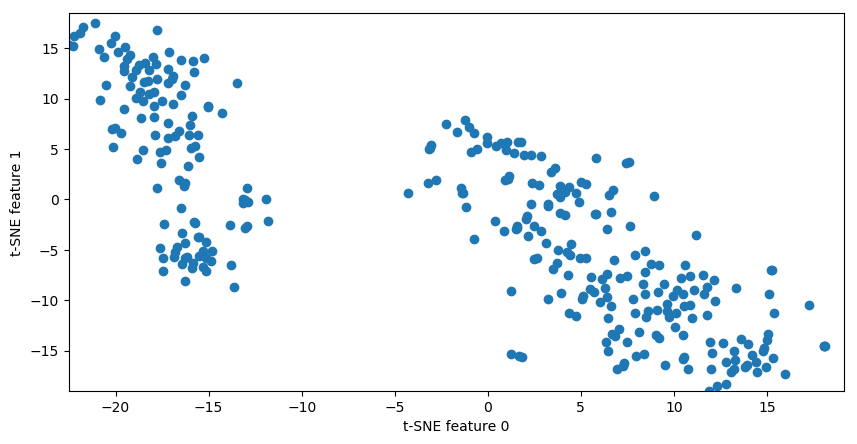

In [34]:
plt.figure(figsize=(10, 5), dpi=100)

# x-y軸の最大、最小の設定
plt.xlim(weekday_hour_tsne[:, 0].min(), weekday_hour_tsne[:, 0].max() + 1)
plt.ylim(weekday_hour_tsne[:, 1].min(), weekday_hour_tsne[:, 1].max() + 1)

plt.scatter(weekday_hour_tsne[:, 0], weekday_hour_tsne[:, 1])

plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

#### K-means++によるクラスタリング（曜日-時間）

In [35]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=1234)

belonged_cluster = km.fit_predict(weekday_hour_tsne)

In [36]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=1234, tol=0.0001, verbose=0)

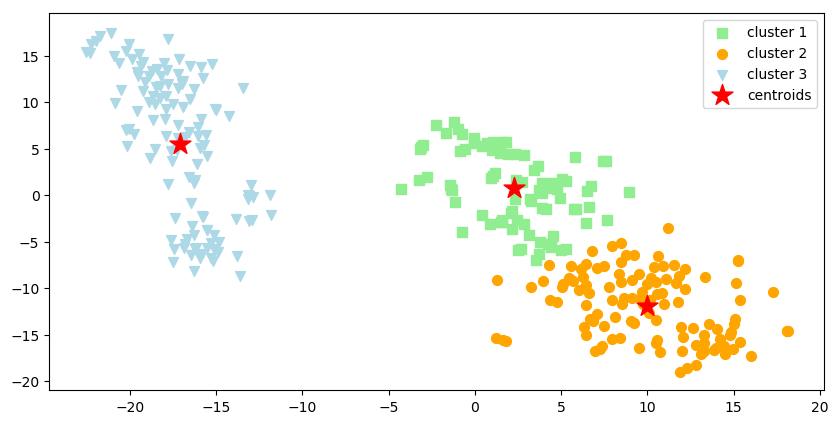

In [37]:
plt.figure(figsize=(10, 5), dpi=100)

plt.scatter(
    weekday_hour_tsne[belonged_cluster == 0, 0],  # belonged_cluster（クラスター番号）が0の時にXの0列目を抽出
    weekday_hour_tsne[belonged_cluster == 0, 1],  # belonged_cluster（クラスター番号）が0の時にXの1列目を抽出
    s=50,
    c='lightgreen',
    marker='s',
    label='cluster 1')

plt.scatter(
    weekday_hour_tsne[belonged_cluster == 1, 0],
    weekday_hour_tsne[belonged_cluster == 1, 1],
    s=50,
    c='orange',
    marker='o',
    label='cluster 2')

plt.scatter(
    weekday_hour_tsne[belonged_cluster == 2, 0],
    weekday_hour_tsne[belonged_cluster == 2, 1],
    s=50,
    c='lightblue',
    marker='v',
    label='cluster 3')

plt.scatter(
    km.cluster_centers_[:, 0],
    km.cluster_centers_[:, 1],
    s=250,
    marker='*',
    c='red',
    label='centroids')

plt.legend()

#### エルボー法によるクラスター数の評価

__エルボー法とは__
- クラスタごとの残差平方和をプロットした図
- クラスター数を増やしていった場合、残差平方和の値が"ヒジ"のようにガクンと曲がった点（残差平方和の値の低下が収束すると思われる場所）が最適なクラスター数とみなす。

Text(0,0.5,'Sum of squared distance')

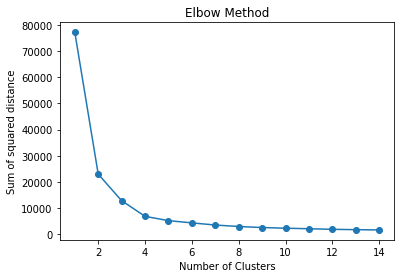

In [38]:
# 残差平方和を格納するリスト
sum_squared_distance = []

# 1～15クラスタまで計算
for i in range(1, 15):

    # n_clusters= i を 動的に変えてSSEを算出
    km = KMeans(n_clusters=i, random_state=1234)

    # クラスタリングの計算を実行
    km.fit(weekday_hour_tsne)

    # SSEを格納
    sum_squared_distance.append(km.inertia_)

plt.plot(range(1, 15), sum_squared_distance, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared distance")

__曜日との兼ね合いから7分類でも問題なさそう__

#### シルエット分析によるクラスター数の評価

__シルエット分析とは__
- クラスタ内のサンプルがどの程度密にグループされているか（凝集度）の目安となるグラフを可視化  
- １つのクラスターが隣接するクラスターとどれくらい離れているかを可視化する
- 厚みが同一クラスターに属するデータ数
- 上手く凝縮していれば、かまぼこ状の形状になる。

Text(0.5,0,'silhouette coefficient')

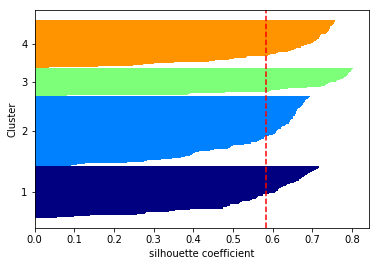

In [39]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

km = KMeans(n_clusters=4, random_state=1234)

# 各データが属するクラスターを算出
belonged_cluster = km.fit_predict(weekday_hour_tsne)

# belonged_cluster 内の重複を排除
cluster_labels = np.unique(belonged_cluster)

# クラスター番号の種類数（＝n_clustersで指定した7）
n_clusters = cluster_labels.shape[0]

# シルエット係数を計算（メトリクスはユークリッド）
silhouette_vals = silhouette_samples(
    weekday_hour_tsne, belonged_cluster, metric='euclidean')

# サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算
y_ax_lower, y_ax_upper = 0, 0

yticks = []

for i, c in enumerate(cluster_labels):

    c_silhouette_vals = silhouette_vals[belonged_cluster == c]

    # cluster_labelsには 0,1,2が入っている（enumerateなのでiにも0,1,2が入ってる（たまたま））
    c_silhouette_vals.sort()

    # サンプルの個数をクラスターごとに足し上げてy軸の最大値を決定
    y_ax_upper += len(c_silhouette_vals)

    # 色の値を作る
    color = cm.jet(float(i) / n_clusters)
    plt.barh(
        range(y_ax_lower, y_ax_upper),  # 水平の棒グラフを描画（底辺の範囲を指定）
        c_silhouette_vals,  # 棒の幅（1サンプルを表す）
        height=1.0,  # 棒の高さ
        edgecolor='none',  # 棒の端の色
        color=color)  # 棒の色

    # クラスタラベルの表示位置を追加
    yticks.append((y_ax_lower + y_ax_upper) / 2)

    # 底辺の値に棒の幅を追加
    y_ax_lower += len(c_silhouette_vals)

# シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)

# 係数の平均値に破線を引く
plt.axvline(silhouette_avg, color="red", linestyle="--")

# クラスタレベルを表示
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')

4-7を試すと、4位がいい感じ。

## ペルソナの分析（曜日-時間）

クラスター数=4とした場合、各クラスターに属しているユーザの消費電力量を抽出する。

In [40]:
weekday_hour_tsne.shape

(319, 2)

In [41]:
# クラスタリング対象の顧客ID一覧
print("### Customer ID \n{} \n".format(weekday_hour_df.columns))

# 各データが属するクラスターを算出
print("### Belonged cluster No \n{}".format(belonged_cluster))

### Customer ID 
Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_354', 'MT_356', 'MT_359', 'MT_360', 'MT_361', 'MT_365', 'MT_366',
       'MT_367', 'MT_368', 'MT_369'],
      dtype='object', length=319) 

### Belonged cluster No 
[2 1 3 3 3 3 3 3 3 2 3 2 2 2 2 3 3 3 3 3 3 2 3 3 3 3 3 3 2 3 3 3 2 3 3 2 3
 2 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2
 3 3 3 3 3 3 2 3 3 3 3 3 2 1 2 2 2 2 2 2 1 0 0 2 1 0 2 3 3 0 0 3 1 0 1 0 0
 1 1 0 2 0 0 0 2 2 2 0 0 2 1 2 1 1 1 0 1 1 1 0 0 0 2 0 2 3 0 2 2 0 2 2 2 2
 3 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 2 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2 2 2 2]


### クラスター毎にユーザを分類

In [42]:
# クラスター 0 に属するインデックス番号を取得
idx_cls_0 = np.where(belonged_cluster == 0)
weekday_hour_df_0 = weekday_hour_df.iloc[:, idx_cls_0[0]]

# クラスター 1 に属するインデックス番号を取得
idx_cls_1 = np.where(belonged_cluster == 1)
weekday_hour_df_1 = weekday_hour_df.iloc[:, idx_cls_1[0]]

# クラスター 2 に属するインデックス番号を取得
idx_cls_2 = np.where(belonged_cluster == 2)
weekday_hour_df_2 = weekday_hour_df.iloc[:, idx_cls_2[0]]

# クラスター 3 に属するインデックス番号を取得
idx_cls_3 = np.where(belonged_cluster == 3)
weekday_hour_df_3 = weekday_hour_df.iloc[:, idx_cls_3[0]]

In [43]:
weekday_hour_df_0.shape, weekday_hour_df_1.shape, weekday_hour_df_2.shape, weekday_hour_df_3.shape

((168, 83), (168, 114), (168, 45), (168, 77))

### 各クラスタを擬人化し、1日の電力量をプロット

#### クラスター 0 の場合（データ数：83）
- 曜日に関係なく、10時 から 20時まで 電気が使用されている。

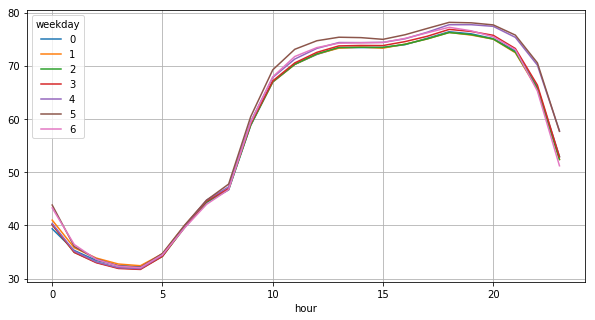

In [44]:
weekday_hour_df_0.mean(axis=1).unstack(0).plot(figsize=(10, 5))
plt.grid()

#### クラスター 1 の場合（データ数：114）
- 曜日に関係なく、6時 から 20時まで 電気が使用されている。
    - クラスター0との違いは、比較的 朝の早い段階から活動している
    - クラスター0に比べて最大消費電力が少ない。

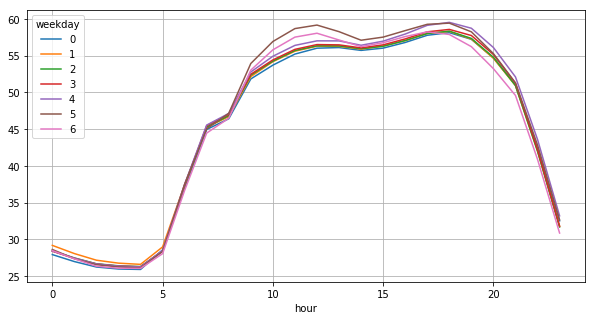

In [45]:
weekday_hour_df_1.mean(axis=1).unstack(0).plot(figsize=(10, 5))
plt.grid()

#### クラスター 2 の場合（データ数：45）
- 週末(weekday 5, 6)は不在が多い、平日は7時から20時までは 電気が使用されている。
- 消費電力量の最大値が少ない為、専業主婦・主夫がいる子供無し夫婦が予想される。

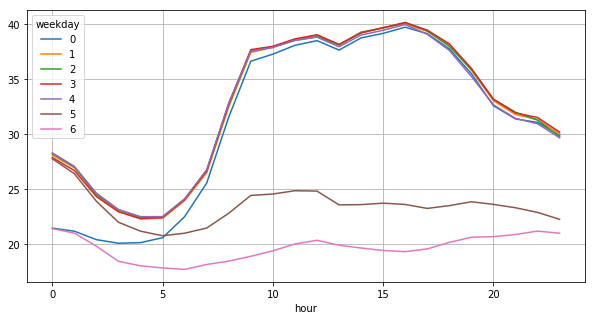

In [46]:
weekday_hour_df_2.mean(axis=1).unstack(0).plot(figsize=(10, 5))
plt.grid()

#### クラスター 3 の場合（データ数：77）
- 曜日に関係なく、日中は不在週末(weekday 5, 6)は不在が多い、19時から22時までは在宅していると思われる。
- 週末は、12時前後は在宅している可能性あり。
- 消費電力量の最大値が少ない為、単身者が予想される。

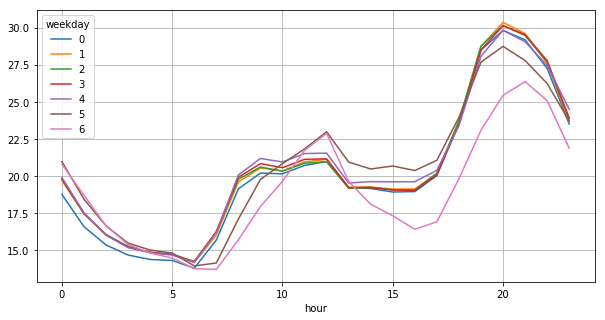

In [47]:
weekday_hour_df_3.mean(axis=1).unstack(0).plot(figsize=(10, 5))
plt.grid()

## ペルソナの分析（月-時間）

Text(0,0.5,'t-SNE feature 1')

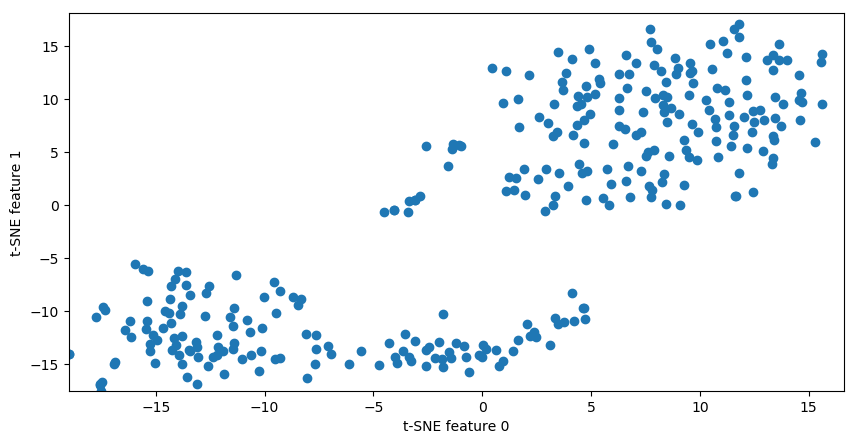

In [48]:
plt.figure(figsize=(10, 5), dpi=100)

# x-y軸の最大、最小の設定
plt.xlim(month_hour_scaled_tsne[:, 0].min(), month_hour_scaled_tsne[:, 0].max() + 1)
plt.ylim(month_hour_scaled_tsne[:, 1].min(), month_hour_scaled_tsne[:, 1].max() + 1)

plt.scatter(month_hour_scaled_tsne[:, 0], month_hour_scaled_tsne[:, 1])

plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

Text(0,0.5,'Sum of squared distance')

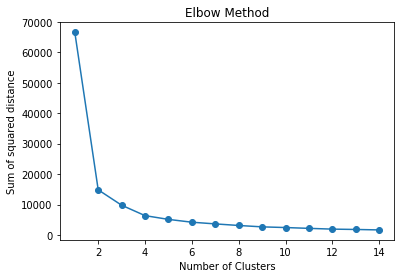

In [49]:
from sklearn.cluster import KMeans

# 残差平方和を格納するリスト
sum_squared_distance = []

# 1～15クラスタまで計算
for i in range(1, 15):

    # n_clusters= i を 動的に変えてSSEを算出
    km = KMeans(n_clusters=i, random_state=1234)

    # クラスタリングの計算を実行
    km.fit(month_hour_scaled_tsne)

    # SSEを格納
    sum_squared_distance.append(km.inertia_)

plt.plot(range(1, 15), sum_squared_distance, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared distance")

Text(0.5,0,'silhouette coefficient')

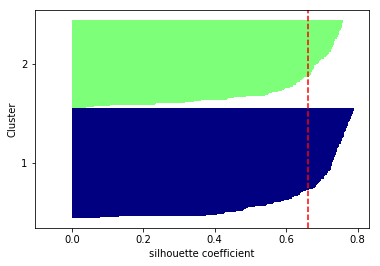

In [50]:
km = KMeans(n_clusters=2, random_state=1234)

# 各データが属するクラスターを算出
belonged_cluster = km.fit_predict(month_hour_scaled_tsne)

# belonged_cluster 内の重複を排除
cluster_labels = np.unique(belonged_cluster)

# クラスター番号の種類数（＝n_clustersで指定した7）
n_clusters = cluster_labels.shape[0]

# シルエット係数を計算（メトリクスはユークリッド）
silhouette_vals = silhouette_samples(
    month_hour_scaled_tsne, belonged_cluster, metric='euclidean')

# サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算
y_ax_lower, y_ax_upper = 0, 0

yticks = []

for i, c in enumerate(cluster_labels):

    c_silhouette_vals = silhouette_vals[belonged_cluster == c]

    # cluster_labelsには 0,1,2が入っている（enumerateなのでiにも0,1,2が入ってる（たまたま））
    c_silhouette_vals.sort()

    # サンプルの個数をクラスターごとに足し上げてy軸の最大値を決定
    y_ax_upper += len(c_silhouette_vals)

    # 色の値を作る
    color = cm.jet(float(i) / n_clusters)
    plt.barh(
        range(y_ax_lower, y_ax_upper),  # 水平の棒グラフを描画（底辺の範囲を指定）
        c_silhouette_vals,  # 棒の幅（1サンプルを表す）
        height=1.0,  # 棒の高さ
        edgecolor='none',  # 棒の端の色
        color=color)  # 棒の色

    # クラスタラベルの表示位置を追加
    yticks.append((y_ax_lower + y_ax_upper) / 2)

    # 底辺の値に棒の幅を追加
    y_ax_lower += len(c_silhouette_vals)

# シルエット係数の平均値
silhouette_avg = np.mean(silhouette_vals)

# 係数の平均値に破線を引く
plt.axvline(silhouette_avg, color="red", linestyle="--")

# クラスタレベルを表示
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')

2位が良い感じ

In [51]:
# クラスター 0 に属するインデックス番号を取得
idx_cls_0 = np.where(belonged_cluster == 0)
month_hour_df_0 = month_hour_df.iloc[:, idx_cls_0[0]]

# クラスター 1 に属するインデックス番号を取得
idx_cls_1 = np.where(belonged_cluster == 1)
month_hour_df_1 = month_hour_df.iloc[:, idx_cls_1[0]]

month_hour_df_0.shape, month_hour_df_1.shape

((84, 177), (84, 142))

#### クラスター 0 の場合（データ数：177）
- 曜日に関係なく、夏場に消費電力量が多くなる。
- 曜日-時間でクラスタリングした場合のクラスター0,1が該当すると思われる。

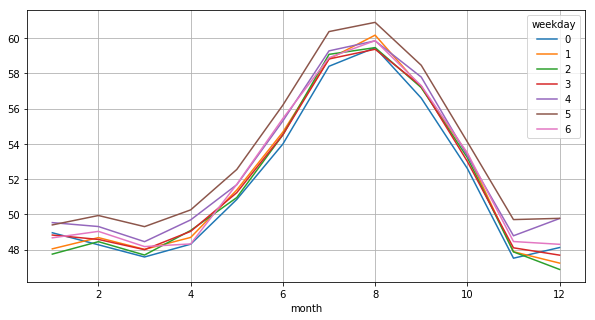

In [52]:
month_hour_df_0.mean(axis=1).unstack(1).plot(figsize=(10, 5))
plt.grid()

#### クラスター 1 の場合（データ数：142）
- 冬場に消費電力量が多くなり、週末は家にいない傾向がある。
- 曜日-時間でクラスタリングした場合のクラスター3,4が該当すると思われる。

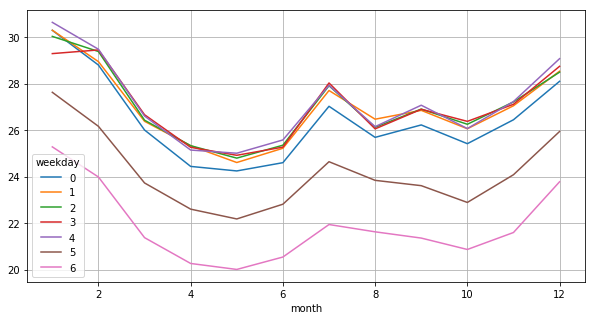

In [53]:
month_hour_df_1.mean(axis=1).unstack(1).plot(figsize=(10, 5))
plt.grid()

__ちなみにUMAPで次元削減した場合__

In [54]:
from scipy.sparse.csgraph import connected_components
import umap.umap_ as umap

# 学習
weekday_hour_umap = umap.UMAP().fit_transform(weekday_hour_scaled)
month_hour_umap = umap.UMAP().fit_transform(month_hour_scaled)

Text(0,0.5,'UMAP feature 1')

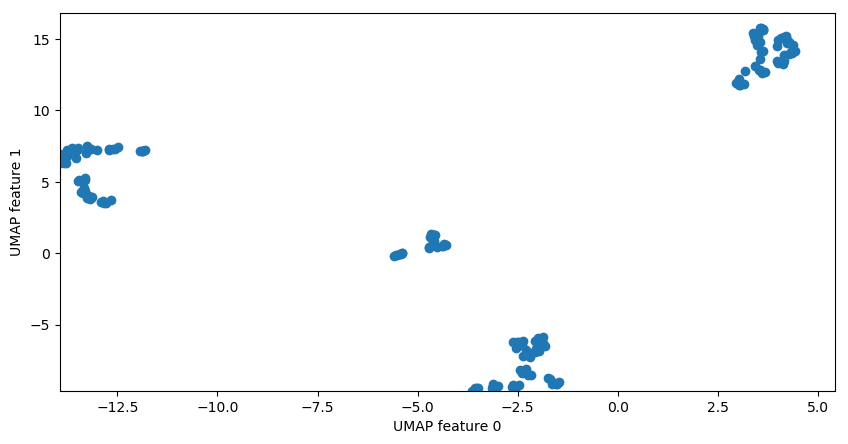

In [55]:
plt.figure(figsize=(10, 5), dpi=100)

# x-y軸の最大、最小の設定
plt.xlim(weekday_hour_umap[:, 0].min(), weekday_hour_umap[:, 0].max() + 1)
plt.ylim(weekday_hour_umap[:, 1].min(), weekday_hour_umap[:, 1].max() + 1)

plt.scatter(weekday_hour_umap[:, 0], weekday_hour_umap[:, 1])

plt.xlabel("UMAP feature 0")
plt.ylabel("UMAP feature 1")

Text(0,0.5,'UMAP feature 1')

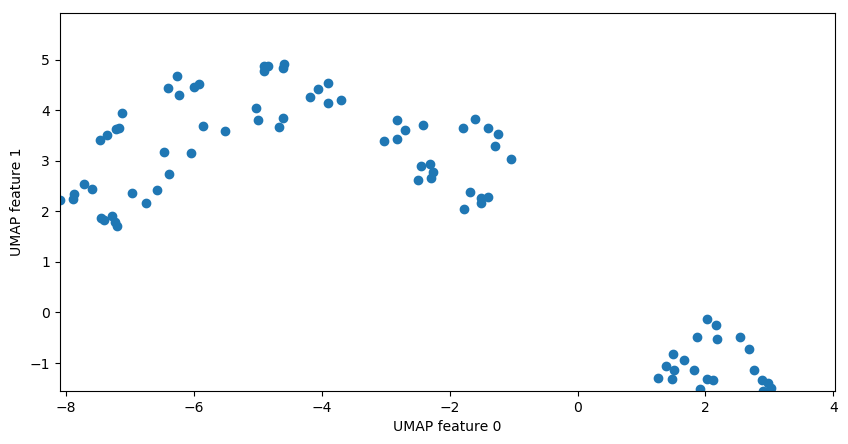

In [56]:
plt.figure(figsize=(10, 5), dpi=100)

# x-y軸の最大、最小の設定
plt.xlim(month_hour_umap[:, 0].min(), month_hour_umap[:, 0].max() + 1)
plt.ylim(month_hour_umap[:, 1].min(), month_hour_umap[:, 1].max() + 1)

plt.scatter(month_hour_umap[:, 0], month_hour_umap[:, 1])

plt.xlabel("UMAP feature 0")
plt.ylabel("UMAP feature 1")